## 1. Import Libraries

In [169]:
import psycopg2

import pandas as pd
import numpy as np

import xgboost as xgb

import tensorflow as tf

from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt

## 2. Connect to DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## 3. Extract Features

### 3.1 Static Features

In [3]:
query = query_schema + \
"""
WITH ht AS
(
  SELECT 
    c.subject_id, c.stay_id, c.charttime,
    -- Ensure that all heights are in centimeters, and fix data as needed
    CASE
        -- rule for neonates
        WHEN pt.anchor_age = 0
         AND (c.valuenum * 2.54) < 80
          THEN c.valuenum * 2.54
        -- rule for adults
        WHEN pt.anchor_age > 0
         AND (c.valuenum * 2.54) > 120
         AND (c.valuenum * 2.54) < 230
          THEN c.valuenum * 2.54
        -- set bad data to NULL
        ELSE NULL
    END AS height
    , ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime DESC) AS rn
  FROM mimiciv.chartevents c
  INNER JOIN mimiciv.patients pt
    ON c.subject_id = pt.subject_id
  WHERE c.valuenum IS NOT NULL
  AND c.valuenum != 0
  AND c.itemid IN
  (
      226707 -- Height (measured in inches)
    -- note we intentionally ignore the below ITEMID in metavision
    -- these are duplicate data in a different unit
    -- , 226730 -- Height (cm)
  )
)
, wt AS
(
    SELECT
        c.stay_id
      , c.charttime
      -- TODO: eliminate obvious outliers if there is a reasonable weight
      , c.valuenum as weight
      , ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime DESC) AS rn
    FROM mimiciv.chartevents c
    WHERE c.valuenum IS NOT NULL
      AND c.itemid = 226512 -- Admit Wt
      AND c.stay_id IS NOT NULL
      AND c.valuenum > 0
)
SELECT
ie.subject_id, ie.hadm_id, ie.stay_id
, CASE WHEN pat.gender = 'M' THEN '1' ELSE '0' END AS is_male
, FLOOR(DATE_PART('day', adm.admittime - make_timestamp(pat.anchor_year, 1, 1, 0, 0, 0))/365.0) + pat.anchor_age as age
, CASE WHEN adm.ethnicity LIKE '%WHITE%' THEN '1' ELSE '0' END AS race_white
, CASE WHEN adm.ethnicity LIKE '%BLACK%' THEN '1' ELSE '0' END AS race_black
, CASE WHEN adm.ethnicity LIKE '%HISPANIC%' THEN '1' ELSE '0' END AS race_hispanic
, CASE WHEN adm.ethnicity LIKE '%ASIAN%' THEN '1' ELSE '0' END AS race_asian
, CASE WHEN adm.ethnicity LIKE '%OTHER%' THEN '1' ELSE '0' END AS race_other
, CASE WHEN adm.admission_type LIKE '%EMER%' THEN '1' ELSE '0' END AS emergency_admission
, CASE
	WHEN ht.height IS NOT null AND wt.weight IS NOT null
		THEN (wt.weight / (ht.height/100*ht.height/100))
	ELSE null
END AS bmi
, ht.height as height
, wt.weight as weight
, (
	SELECT
	CASE WHEN COUNT(*) = 0 THEN 0 ELSE 1 END
	FROM mimiciv.transfers car_trs
	WHERE car_trs.hadm_id = adm.hadm_id
	AND lower(car_trs.careunit) LIKE '%card%'
	AND lower(car_trs.careunit) LIKE '%surg%'
) AS service_any_card_surg
, (
	SELECT
	CASE WHEN COUNT(*) = 0 THEN 0 ELSE 1 END
	FROM mimiciv.transfers car_trs
	WHERE car_trs.hadm_id = adm.hadm_id
	AND lower(car_trs.careunit) NOT LIKE '%card%'
	AND lower(car_trs.careunit) LIKE '%surg%'
) AS service_any_noncard_surg
, (
	SELECT
	CASE WHEN COUNT(*) = 0 THEN 0 ELSE 1 END
	FROM mimiciv.transfers car_trs
	WHERE car_trs.hadm_id = adm.hadm_id
	AND lower(car_trs.careunit) LIKE '%trauma%'
) AS service_trauma
-- , adm.hospital_expire_flag
FROM mimiciv.icustays ie
INNER JOIN mimiciv.admissions adm
ON ie.hadm_id = adm.hadm_id
INNER JOIN mimiciv.patients pat
ON ie.subject_id = pat.subject_id
LEFT JOIN ht
ON ie.stay_id = ht.stay_id AND ht.rn = 1
LEFT JOIN wt
ON ie.stay_id = wt.stay_id AND wt.rn = 1
"""

static = pd.read_sql_query(query,con)

In [4]:
static

,subject_id,hadm_id,stay_id,is_male,age,race_white,race_black,race_hispanic,race_asian,race_other,emergency_admission,bmi,height,weight,service_any_card_surg,service_any_noncard_surg,service_trauma
0,14485852,28712010,37142417,1,57.0,1,0,0,0,0,1,NaN,NaN,84.0,0,1,0
1,10222255,28200985,30847801,0,70.0,1,0,0,0,0,0,NaN,NaN,72.3,0,0,0
2,19119203,21682799,32710648,0,55.0,1,0,0,0,0,0,NaN,NaN,61.2,0,0,0
3,16837807,23526268,34674644,0,67.0,1,0,0,0,0,0,NaN,NaN,85.0,0,0,0
4,18230965,21251728,30630840,0,36.0,1,0,0,0,0,0,NaN,NaN,69.4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,11280984,29950184,38925361,0,60.0,1,0,0,0,0,1,NaN,NaN,73.0,0,1,0
76536,16084602,24957319,37666626,1,41.0,0,1,0,0,0,1,NaN,NaN,104.6,0,0,0
76537,19902791,27957067,35897554,0,57.0,0,1,0,0,0,1,39.107771,165.10,106.6,0,1,0
76538,19957626,23821950,38817551,0,64.0,1,0,0,0,0,1,NaN,NaN,65.0,0,1,0


### 3.2 First Lab Measurement Attributes

In [5]:
query = query_schema + \
"""
WITH labs_preceeding AS
(
	SELECT icu.stay_id, l.valuenum, l.charttime
	, CASE
			WHEN itemid = 51006 THEN 'BUN'
			WHEN itemid = 50806 THEN 'CHLORIDE'
			WHEN itemid = 50902 THEN 'CHLORIDE'
			WHEN itemid = 50912 THEN 'CREATININE'
			WHEN itemid = 50811 THEN 'HEMOGLOBIN'
			WHEN itemid = 51222 THEN 'HEMOGLOBIN'
			WHEN itemid = 51265 THEN 'PLATELET'
			WHEN itemid = 50822 THEN 'POTASSIUM'
			WHEN itemid = 50971 THEN 'POTASSIUM'
			WHEN itemid = 50824 THEN 'SODIUM'
			WHEN itemid = 50983 THEN 'SODIUM'
			WHEN itemid = 50803 THEN 'BICARBONATE'
			WHEN itemid = 50882 THEN 'BICARBONATE'
			WHEN itemid = 50804 THEN 'TOTALCO2'
			WHEN itemid = 50821 THEN 'PO2'
			WHEN itemid = 52042 THEN 'PO2'
			WHEN itemid = 50832 THEN 'PO2'
			WHEN itemid = 50818 THEN 'PCO2'
			WHEN itemid = 52040 THEN 'PCO2'
			WHEN itemid = 50830 THEN 'PCO2'
			WHEN itemid = 50820 THEN 'PH'
			WHEN itemid = 52041 THEN 'PH'
			WHEN itemid = 50831 THEN 'PH'
			WHEN itemid = 51300 THEN 'WBC'
			WHEN itemid = 51301 THEN 'WBC'
			WHEN itemid = 50802 THEN 'BASEEXCESS'
			WHEN itemid = 52038 THEN 'BASEEXCESS'
			WHEN itemid = 50805 THEN 'CARBOXYHEMOGLOBIN'
			WHEN itemid = 50814 THEN 'METHEMOGLOBIN'
			WHEN itemid = 50868 THEN 'ANIONGAP'
			WHEN itemid = 52500 THEN 'ANIONGAP'
			WHEN itemid = 50862 THEN 'ALBUMIN'
			WHEN itemid = 51144 THEN 'BANDS'
			WHEN itemid = 50885 THEN 'BILRUBIN'
			WHEN itemid = 51478 THEN 'GLUCOSE'
			WHEN itemid = 50931 THEN 'GLUCOSE'
			WHEN itemid = 51221 THEN 'HEMATOCRIT'
			WHEN itemid = 50813 THEN 'LACTATE'
			WHEN itemid = 51275 THEN 'PTT'
			WHEN itemid = 51237 THEN 'INR'
		  ELSE null
		END AS LABEL
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.admissions adm
	ON icu.hadm_id = adm.hadm_id
	INNER JOIN mimiciv.patients pat
	ON icu.subject_id = pat.subject_id
	INNER JOIN mimiciv.labevents l
	ON l.hadm_id = icu.hadm_id
	AND l.charttime >= icu.intime - interval '8 hour'
	AND l.charttime <= icu.intime + interval '24 hour'
	WHERE l.itemid IN
	(
	 51300,51301 -- wbc
	, 50811,51222 -- hgb
	, 51265 -- platelet
	, 50824, 50983 -- sodium
	, 50822, 50971 -- potassium
	, 50804 -- Total CO2 or ...
	, 50803, 50882  -- bicarbonate
	, 50806, 50902 -- chloride
	, 51006 -- bun
	, 50912 -- creatinine
	, 50821, 52042, 50832 -- po2
	, 50818, 52040, 50830 -- pco2
	, 50820, 52041, 50831 -- ph
	, 50802, 52038 -- Base Excess
	, 50805 -- carboxyhemoglobin
	, 50814 -- methemoglobin
	, 50868, 52500 -- aniongap
	, 50862 -- albumin
	, 51144 -- bands
	, 50885 -- bilrubin
	, 51478, 50931 -- glucose
	, 51221 -- hematocrit
	, 50813 -- lactate
	, 51275 -- ptt
	, 51237 -- inr
	)
	AND valuenum IS NOT null
)
, labs_rn AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
  FROM labs_preceeding
)
, labs_grp AS
(
  SELECT
    stay_id
    , COALESCE(MAX(CASE WHEN label = 'BUN' THEN valuenum ELSE null END)) AS BUN
    , COALESCE(MAX(CASE WHEN label = 'CHLORIDE' THEN valuenum ELSE null END)) AS CHLORIDE
    , COALESCE(MAX(CASE WHEN label = 'CREATININE' THEN valuenum ELSE null END)) AS CREATININE
    , COALESCE(MAX(CASE WHEN label = 'HEMOGLOBIN' THEN valuenum ELSE null END)) AS HEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'PLATELET' THEN valuenum ELSE null END)) AS PLATELET
    , COALESCE(MAX(CASE WHEN label = 'POTASSIUM' THEN valuenum ELSE null END)) AS POTASSIUM
    , COALESCE(MAX(CASE WHEN label = 'SODIUM' THEN valuenum ELSE null END)) AS SODIUM
    , COALESCE(MAX(CASE WHEN label = 'TOTALCO2' THEN valuenum ELSE null END)) AS TOTALCO2
    , COALESCE(MAX(CASE WHEN label = 'WBC' THEN valuenum ELSE null END)) AS WBC
    , COALESCE(MAX(CASE WHEN label = 'PO2' THEN valuenum ELSE null END)) AS PO2
    , COALESCE(MAX(CASE WHEN label = 'PCO2' THEN valuenum ELSE null END)) AS PCO2
    , COALESCE(MAX(CASE WHEN label = 'PH' THEN valuenum ELSE null END)) AS PH
    , COALESCE(MAX(CASE WHEN label = 'BASEEXCESS' THEN valuenum ELSE null END)) AS BASEEXCESS
    , COALESCE(MAX(CASE WHEN label = 'CARBOXYHEMOGLOBIN' THEN valuenum ELSE null END)) AS CARBOXYHEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'METHEMOGLOBIN' THEN valuenum ELSE null END)) AS METHEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'ANIONGAP' THEN valuenum ELSE null END)) AS ANIONGAP
    , COALESCE(MAX(CASE WHEN label = 'ALBUMIN' THEN valuenum ELSE null END)) AS ALBUMIN
    , COALESCE(MAX(CASE WHEN label = 'BANDS' THEN valuenum ELSE null END)) AS BANDS
    , COALESCE(MAX(CASE WHEN label = 'BICARBONATE' THEN valuenum ELSE null END)) AS BICARBONATE
    , COALESCE(MAX(CASE WHEN label = 'BILRUBIN' THEN valuenum ELSE null END)) AS BILRUBIN
    , COALESCE(MAX(CASE WHEN label = 'GLUCOSE' THEN valuenum ELSE null END)) AS GLUCOSE
    , COALESCE(MAX(CASE WHEN label = 'HEMATOCRIT' THEN valuenum ELSE null END)) AS HEMATOCRIT
    , COALESCE(MAX(CASE WHEN label = 'LACTATE' THEN valuenum ELSE null END)) AS LACTATE
    , COALESCE(MAX(CASE WHEN label = 'PTT' THEN valuenum ELSE null END)) AS PTT
    , COALESCE(MAX(CASE WHEN label = 'INR' THEN valuenum ELSE null END)) AS INR
  FROM labs_rn
  WHERE rn = 1
  GROUP BY stay_id
)
SELECT icu.stay_id
  , lg.bun AS bun_first
  , lg.chloride AS chloride_first
  , lg.creatinine AS creatinine_first
  , lg.HEMOGLOBIN AS hgb_first
  , lg.platelet AS platelet_first
  , lg.potassium AS potassium_first
  , lg.sodium AS sodium_first
  , lg.TOTALCO2 AS tco2_first
  , lg.wbc AS wbc_first
  , lg.po2 AS bg_po2_first
  , lg.pco2 AS bg_pco2_first
  , lg.ph AS bg_ph_first
  , lg.BASEEXCESS AS bg_baseexcess_first
  , lg.CARBOXYHEMOGLOBIN AS bg_carboxyhemoglobin_first
  , lg.METHEMOGLOBIN AS bg_methemomoglobin_first
  , lg.ANIONGAP AS aniongap_first
  , lg.ALBUMIN AS albumin_first
  , lg.BANDS AS bands_first
  , lg.BICARBONATE AS bicarbonate_first
  , lg.BILRUBIN AS bilrubin_first
  , lg.GLUCOSE AS glucose_first
  , lg.HEMATOCRIT AS hematocrit_first
  , lg.LACTATE AS lactate_first
  , lg.PTT AS ptt_first
  , lg.INR AS inr_first
FROM mimiciv.icustays icu
LEFT JOIN labs_grp lg
ON icu.stay_id = lg.stay_id
"""

first_lab = pd.read_sql_query(query,con)

In [6]:
first_lab

,stay_id,bun_first,chloride_first,creatinine_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first,...,aniongap_first,albumin_first,bands_first,bicarbonate_first,bilrubin_first,glucose_first,hematocrit_first,lactate_first,ptt_first,inr_first
0,30000153,22.0,110.0,0.9,12.5,173.0,4.4,141.0,23.0,17.0,...,12.0,NaN,NaN,19.0,NaN,192.0,35.0,1.3,25.3,1.1
1,30000213,61.0,102.0,3.7,7.4,226.0,4.8,140.0,27.0,5.8,...,16.0,NaN,NaN,22.0,0.3,176.0,23.9,0.9,NaN,NaN
2,30000484,47.0,104.0,1.2,8.1,357.0,5.4,136.0,33.0,24.2,...,10.0,2.5,1.0,27.0,0.3,94.0,24.6,2.0,36.1,1.4
3,30000646,12.0,105.0,0.9,12.9,268.0,3.5,138.0,21.0,8.5,...,12.0,NaN,NaN,25.0,0.7,102.0,37.8,1.6,37.4,1.3
4,30001148,9.0,105.0,0.6,12.0,160.0,3.9,132.0,30.0,7.4,...,10.0,NaN,NaN,27.0,NaN,119.0,25.2,0.9,27.3,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,39999301,17.0,109.0,1.5,12.5,197.0,3.4,142.0,26.0,9.3,...,12.0,4.1,NaN,24.0,0.4,114.0,36.1,1.9,26.5,1.1
76536,39999384,91.0,103.0,2.2,8.0,176.0,3.7,143.0,NaN,10.9,...,16.0,NaN,NaN,24.0,NaN,116.0,24.8,NaN,NaN,NaN
76537,39999552,10.0,102.0,0.6,12.6,163.0,3.0,139.0,28.0,9.0,...,9.0,NaN,NaN,27.0,NaN,94.0,26.1,1.4,26.5,1.5
76538,39999562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3 Last Lab Measurement Attributes

In [7]:
query = query_schema + \
"""
WITH labs_preceeding AS
(
	SELECT icu.stay_id, l.valuenum, l.charttime
	, CASE
			WHEN itemid = 51006 THEN 'BUN'
			WHEN itemid = 50806 THEN 'CHLORIDE'
			WHEN itemid = 50902 THEN 'CHLORIDE'
			WHEN itemid = 50912 THEN 'CREATININE'
			WHEN itemid = 50811 THEN 'HEMOGLOBIN'
			WHEN itemid = 51222 THEN 'HEMOGLOBIN'
			WHEN itemid = 51265 THEN 'PLATELET'
			WHEN itemid = 50822 THEN 'POTASSIUM'
			WHEN itemid = 50971 THEN 'POTASSIUM'
			WHEN itemid = 50824 THEN 'SODIUM'
			WHEN itemid = 50983 THEN 'SODIUM'
			WHEN itemid = 50803 THEN 'BICARBONATE'
			WHEN itemid = 50882 THEN 'BICARBONATE'
			WHEN itemid = 50804 THEN 'TOTALCO2'
			WHEN itemid = 50821 THEN 'PO2'
			WHEN itemid = 52042 THEN 'PO2'
			WHEN itemid = 50832 THEN 'PO2'
			WHEN itemid = 50818 THEN 'PCO2'
			WHEN itemid = 52040 THEN 'PCO2'
			WHEN itemid = 50830 THEN 'PCO2'
			WHEN itemid = 50820 THEN 'PH'
			WHEN itemid = 52041 THEN 'PH'
			WHEN itemid = 50831 THEN 'PH'
			WHEN itemid = 51300 THEN 'WBC'
			WHEN itemid = 51301 THEN 'WBC'
			WHEN itemid = 50802 THEN 'BASEEXCESS'
			WHEN itemid = 52038 THEN 'BASEEXCESS'
			WHEN itemid = 50805 THEN 'CARBOXYHEMOGLOBIN'
			WHEN itemid = 50814 THEN 'METHEMOGLOBIN'
			WHEN itemid = 50868 THEN 'ANIONGAP'
			WHEN itemid = 52500 THEN 'ANIONGAP'
			WHEN itemid = 50862 THEN 'ALBUMIN'
			WHEN itemid = 51144 THEN 'BANDS'
			WHEN itemid = 50885 THEN 'BILRUBIN'
			WHEN itemid = 51478 THEN 'GLUCOSE'
			WHEN itemid = 50931 THEN 'GLUCOSE'
			WHEN itemid = 51221 THEN 'HEMATOCRIT'
			WHEN itemid = 50813 THEN 'LACTATE'
			WHEN itemid = 51275 THEN 'PTT'
			WHEN itemid = 51237 THEN 'INR'
		  ELSE null
		END AS LABEL
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.admissions adm
	ON icu.hadm_id = adm.hadm_id
	INNER JOIN mimiciv.patients pat
	ON icu.subject_id = pat.subject_id
	INNER JOIN mimiciv.labevents l
	ON l.hadm_id = icu.hadm_id
	AND l.charttime >= icu.intime - interval '8 hour'
	AND l.charttime <= icu.intime + interval '24 hour'
	WHERE l.itemid IN
	(
	 51300,51301 -- wbc
	, 50811,51222 -- hgb
	, 51265 -- platelet
	, 50824, 50983 -- sodium
	, 50822, 50971 -- potassium
	, 50804 -- Total CO2 or ...
	, 50803, 50882  -- bicarbonate
	, 50806, 50902 -- chloride
	, 51006 -- bun
	, 50912 -- creatinine
	, 50821, 52042, 50832 -- po2
	, 50818, 52040, 50830 -- pco2
	, 50820, 52041, 50831 -- ph
	, 50802, 52038 -- Base Excess
	, 50805 -- carboxyhemoglobin
	, 50814 -- methemoglobin
	, 50868, 52500 -- aniongap
	, 50862 -- albumin
	, 51144 -- bands
	, 50885 -- bilrubin
	, 51478, 50931 -- glucose
	, 51221 -- hematocrit
	, 50813 -- lactate
	, 51275 -- ptt
	, 51237 -- inr
	)
	AND valuenum IS NOT null
)
, labs_rn AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime DESC) AS rn
  FROM labs_preceeding
)
, labs_grp AS
(
  SELECT
    stay_id
    , COALESCE(MAX(CASE WHEN label = 'BUN' THEN valuenum ELSE null END)) AS BUN
    , COALESCE(MAX(CASE WHEN label = 'CHLORIDE' THEN valuenum ELSE null END)) AS CHLORIDE
    , COALESCE(MAX(CASE WHEN label = 'CREATININE' THEN valuenum ELSE null END)) AS CREATININE
    , COALESCE(MAX(CASE WHEN label = 'HEMOGLOBIN' THEN valuenum ELSE null END)) AS HEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'PLATELET' THEN valuenum ELSE null END)) AS PLATELET
    , COALESCE(MAX(CASE WHEN label = 'POTASSIUM' THEN valuenum ELSE null END)) AS POTASSIUM
    , COALESCE(MAX(CASE WHEN label = 'SODIUM' THEN valuenum ELSE null END)) AS SODIUM
    , COALESCE(MAX(CASE WHEN label = 'TOTALCO2' THEN valuenum ELSE null END)) AS TOTALCO2
    , COALESCE(MAX(CASE WHEN label = 'WBC' THEN valuenum ELSE null END)) AS WBC
    , COALESCE(MAX(CASE WHEN label = 'PO2' THEN valuenum ELSE null END)) AS PO2
    , COALESCE(MAX(CASE WHEN label = 'PCO2' THEN valuenum ELSE null END)) AS PCO2
    , COALESCE(MAX(CASE WHEN label = 'PH' THEN valuenum ELSE null END)) AS PH
    , COALESCE(MAX(CASE WHEN label = 'BASEEXCESS' THEN valuenum ELSE null END)) AS BASEEXCESS
    , COALESCE(MAX(CASE WHEN label = 'CARBOXYHEMOGLOBIN' THEN valuenum ELSE null END)) AS CARBOXYHEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'METHEMOGLOBIN' THEN valuenum ELSE null END)) AS METHEMOGLOBIN
    , COALESCE(MAX(CASE WHEN label = 'ANIONGAP' THEN valuenum ELSE null END)) AS ANIONGAP
    , COALESCE(MAX(CASE WHEN label = 'ALBUMIN' THEN valuenum ELSE null END)) AS ALBUMIN
    , COALESCE(MAX(CASE WHEN label = 'BANDS' THEN valuenum ELSE null END)) AS BANDS
    , COALESCE(MAX(CASE WHEN label = 'BICARBONATE' THEN valuenum ELSE null END)) AS BICARBONATE
    , COALESCE(MAX(CASE WHEN label = 'BILRUBIN' THEN valuenum ELSE null END)) AS BILRUBIN
    , COALESCE(MAX(CASE WHEN label = 'GLUCOSE' THEN valuenum ELSE null END)) AS GLUCOSE
    , COALESCE(MAX(CASE WHEN label = 'HEMATOCRIT' THEN valuenum ELSE null END)) AS HEMATOCRIT
    , COALESCE(MAX(CASE WHEN label = 'LACTATE' THEN valuenum ELSE null END)) AS LACTATE
    , COALESCE(MAX(CASE WHEN label = 'PTT' THEN valuenum ELSE null END)) AS PTT
    , COALESCE(MAX(CASE WHEN label = 'INR' THEN valuenum ELSE null END)) AS INR
  FROM labs_rn
  WHERE rn = 1
  GROUP BY stay_id
)
SELECT icu.stay_id
  , lg.bun AS bun_last
  , lg.chloride AS chloride_last
  , lg.creatinine AS creatinine_last
  , lg.HEMOGLOBIN AS hgb_last
  , lg.platelet AS platelet_last
  , lg.potassium AS potassium_last
  , lg.sodium AS sodium_last
  , lg.TOTALCO2 AS tco2_last
  , lg.wbc AS wbc_last
  , lg.po2 AS bg_po2_last
  , lg.pco2 AS bg_pco2_last
  , lg.ph AS bg_ph_last
  , lg.BASEEXCESS AS bg_baseexcess_last
  , lg.CARBOXYHEMOGLOBIN AS bg_carboxyhemoglobin_last
  , lg.METHEMOGLOBIN AS bg_methemomoglobin_last
  , lg.ANIONGAP AS aniongap_last
  , lg.ALBUMIN AS albumin_last
  , lg.BANDS AS bands_last
  , lg.BICARBONATE AS bicarbonate_last
  , lg.BILRUBIN AS bilrubin_last
  , lg.GLUCOSE AS glucose_last
  , lg.HEMATOCRIT AS hematocrit_last
  , lg.LACTATE AS lactate_last
  , lg.PTT AS ptt_last
  , lg.INR AS inr_last
FROM mimiciv.icustays icu
LEFT JOIN labs_grp lg
ON icu.stay_id = lg.stay_id
"""

last_lab = pd.read_sql_query(query,con)

In [8]:
last_lab

,stay_id,bun_last,chloride_last,creatinine_last,hgb_last,platelet_last,potassium_last,sodium_last,tco2_last,wbc_last,...,aniongap_last,albumin_last,bands_last,bicarbonate_last,bilrubin_last,glucose_last,hematocrit_last,lactate_last,ptt_last,inr_last
0,30000153,22.0,115.0,1.1,9.8,162.0,4.8,145.0,22.0,15.2,...,12.0,NaN,NaN,23.0,NaN,144.0,29.1,2.1,25.3,1.1
1,30000213,61.0,98.0,3.6,7.4,226.0,4.5,139.0,27.0,5.8,...,17.0,NaN,NaN,24.0,0.3,275.0,23.9,0.9,NaN,NaN
2,30000484,47.0,104.0,1.2,8.1,357.0,5.2,136.0,33.0,24.2,...,10.0,2.5,1.0,27.0,0.3,94.0,24.6,1.6,36.1,1.4
3,30000646,9.0,116.0,0.6,12.9,266.0,4.2,143.0,21.0,7.9,...,13.0,NaN,NaN,18.0,0.7,144.0,38.3,1.6,35.3,1.3
4,30001148,12.0,108.0,0.6,10.8,198.0,4.7,138.0,27.0,11.7,...,10.0,NaN,NaN,25.0,NaN,119.0,32.3,1.5,29.5,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,39999301,22.0,110.0,1.8,9.5,137.0,4.3,136.0,17.0,8.0,...,15.0,4.1,NaN,23.0,0.4,132.0,28.7,6.0,34.7,1.4
76536,39999384,91.0,103.0,2.2,7.7,159.0,3.7,143.0,NaN,10.3,...,16.0,NaN,NaN,24.0,NaN,116.0,23.4,NaN,NaN,NaN
76537,39999552,10.0,102.0,0.8,10.6,174.0,3.4,139.0,27.0,9.8,...,14.0,NaN,NaN,25.0,NaN,94.0,30.5,2.2,29.4,1.1
76538,39999562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.4 First Vitals Measurement Attributes

In [9]:
query = query_schema + \
"""
WITH vitals_stg_1 AS
(
	SELECT icu.stay_id, cev.charttime
	, CASE
			WHEN itemid = 223761 THEN (cev.valuenum-32)/1.8
		ELSE cev.valuenum
	END AS valuenum
	, CASE
			WHEN itemid = 220045 THEN 'HEARTRATE'
			WHEN itemid = 220050 THEN 'SYSBP'
			WHEN itemid = 220179 THEN 'SYSBP'
			WHEN itemid = 220051 THEN 'DIASBP'
			WHEN itemid = 220180 THEN 'DIASBP'
			WHEN itemid = 220052 THEN 'MEANBP'
			WHEN itemid = 220181 THEN 'MEANBP'
			WHEN itemid = 225312 THEN 'MEANBP'
			WHEN itemid = 220210 THEN 'RESPRATE'
			WHEN itemid = 224688 THEN 'RESPRATE'
			WHEN itemid = 224689 THEN 'RESPRATE'
			WHEN itemid = 224690 THEN 'RESPRATE'
			WHEN itemid = 223761 THEN 'TEMPC'
			WHEN itemid = 223762 THEN 'TEMPC'
			WHEN itemid = 220277 THEN 'SPO2'
			WHEN itemid = 220739 THEN 'GCSEYE'
			WHEN itemid = 223900 THEN 'GCSVERBAL'
			WHEN itemid = 223901 THEN 'GCSMOTOR'
		  ELSE null
		END AS label
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.chartevents cev
	ON cev.stay_id = icu.stay_id
	AND cev.charttime >= icu.intime
	AND cev.charttime <= icu.intime + interval '24 hour'
	WHERE cev.itemid IN
	(
	 220045 -- heartrate
	, 220050, 220179 -- sysbp
	, 220051, 220180 -- diasbp
	, 220052, 220181, 225312 -- meanbp
	, 220210, 224688, 224689, 224690 -- resprate
	, 223761, 223762 -- tempc
	, 220277 -- SpO2
	, 220739 -- gcseye
	, 223900 -- gcsverbal
	, 223901 -- gscmotor
	)
	AND valuenum IS NOT null
)
, vitals_stg_2 AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
  FROM vitals_stg_1
)
, vitals_stg_3 AS
(
  SELECT
    stay_id
    , COALESCE(MAX(CASE WHEN label = 'HEARTRATE' THEN valuenum ELSE null END)) AS heartrate_first
    , COALESCE(MAX(CASE WHEN label = 'SYSBP' THEN valuenum ELSE null END)) AS sysbp_first
    , COALESCE(MAX(CASE WHEN label = 'DIASBP' THEN valuenum ELSE null END)) AS diabp_first
    , COALESCE(MAX(CASE WHEN label = 'MEANBP' THEN valuenum ELSE null END)) AS meanbp_first
    , COALESCE(MAX(CASE WHEN label = 'RESPRATE' THEN valuenum ELSE null END)) AS resprate_first
    , COALESCE(MAX(CASE WHEN label = 'TEMPC' THEN valuenum ELSE null END)) AS tempc_first
    , COALESCE(MAX(CASE WHEN label = 'SPO2' THEN valuenum ELSE null END)) AS spo2_first
    , COALESCE(MAX(CASE WHEN label = 'GCSEYE' THEN valuenum ELSE null END)) AS gcseye_first
    , COALESCE(MAX(CASE WHEN label = 'GCSVERBAL' THEN valuenum ELSE null END)) AS gcsverbal_first
    , COALESCE(MAX(CASE WHEN label = 'GCSMOTOR' THEN valuenum ELSE null END)) AS gcsmotor_first
  FROM vitals_stg_2
  WHERE rn = 1
  GROUP BY stay_id
)
SELECT * FROM vitals_stg_3
"""

first_vitals = pd.read_sql_query(query,con)

In [10]:
first_vitals

,stay_id,heartrate_first,sysbp_first,diabp_first,meanbp_first,resprate_first,tempc_first,spo2_first,gcseye_first,gcsverbal_first,gcsmotor_first
0,30000153,104.0,113.0,77.0,84.0,18.0,37.277778,100.0,3.0,1.0,5.0
1,30000213,74.0,168.0,65.0,95.0,24.0,36.333333,96.0,2.0,1.0,4.0
2,30000484,106.0,101.0,75.0,81.0,22.0,35.555556,100.0,4.0,1.0,1.0
3,30000646,100.0,107.0,66.0,75.0,28.0,37.111111,97.0,4.0,5.0,6.0
4,30001148,80.0,107.0,64.0,78.0,15.0,35.333333,100.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
76443,39999301,58.0,169.0,148.0,153.0,15.0,36.611111,95.0,4.0,5.0,6.0
76444,39999384,77.0,211.0,64.0,113.0,17.0,36.777778,100.0,4.0,5.0,6.0
76445,39999552,66.0,125.0,60.0,84.0,14.0,36.777778,100.0,1.0,1.0,1.0
76446,39999562,93.0,101.0,79.0,87.0,NaN,36.888889,94.0,4.0,5.0,6.0


### 3.5 Last Vitals Measurement Attributes

In [11]:
query = query_schema + \
"""
WITH vitals_stg_1 AS
(
	SELECT icu.stay_id, cev.charttime
	, CASE
			WHEN itemid = 223761 THEN (cev.valuenum-32)/1.8
		ELSE cev.valuenum
	END AS valuenum
	, CASE
			WHEN itemid = 220045 THEN 'HEARTRATE'
			WHEN itemid = 220050 THEN 'SYSBP'
			WHEN itemid = 220179 THEN 'SYSBP'
			WHEN itemid = 220051 THEN 'DIASBP'
			WHEN itemid = 220180 THEN 'DIASBP'
			WHEN itemid = 220052 THEN 'MEANBP'
			WHEN itemid = 220181 THEN 'MEANBP'
			WHEN itemid = 225312 THEN 'MEANBP'
			WHEN itemid = 220210 THEN 'RESPRATE'
			WHEN itemid = 224688 THEN 'RESPRATE'
			WHEN itemid = 224689 THEN 'RESPRATE'
			WHEN itemid = 224690 THEN 'RESPRATE'
			WHEN itemid = 223761 THEN 'TEMPC'
			WHEN itemid = 223762 THEN 'TEMPC'
			WHEN itemid = 220277 THEN 'SPO2'
			WHEN itemid = 220739 THEN 'GCSEYE'
			WHEN itemid = 223900 THEN 'GCSVERBAL'
			WHEN itemid = 223901 THEN 'GCSMOTOR'
		  ELSE null
		END AS label
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.chartevents cev
	ON cev.stay_id = icu.stay_id
	AND cev.charttime >= icu.intime
	AND cev.charttime <= icu.intime + interval '24 hour'
	WHERE cev.itemid IN
	(
	 220045 -- heartrate
	, 220050, 220179 -- sysbp
	, 220051, 220180 -- diasbp
	, 220052, 220181, 225312 -- meanbp
	, 220210, 224688, 224689, 224690 -- resprate
	, 223761, 223762 -- tempc
	, 220277 -- SpO2
	, 220739 -- gcseye
	, 223900 -- gcsverbal
	, 223901 -- gscmotor
	)
	AND valuenum IS NOT null
)
, vitals_stg_2 AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime DESC) AS rn
  FROM vitals_stg_1
)
, vitals_stg_3 AS
(
  SELECT
    stay_id
    , COALESCE(MAX(CASE WHEN label = 'HEARTRATE' THEN valuenum ELSE null END)) AS heartrate_last
    , COALESCE(MAX(CASE WHEN label = 'SYSBP' THEN valuenum ELSE null END)) AS sysbp_last
    , COALESCE(MAX(CASE WHEN label = 'DIASBP' THEN valuenum ELSE null END)) AS diabp_last
    , COALESCE(MAX(CASE WHEN label = 'MEANBP' THEN valuenum ELSE null END)) AS meanbp_last
    , COALESCE(MAX(CASE WHEN label = 'RESPRATE' THEN valuenum ELSE null END)) AS resprate_last
    , COALESCE(MAX(CASE WHEN label = 'TEMPC' THEN valuenum ELSE null END)) AS tempc_last
    , COALESCE(MAX(CASE WHEN label = 'SPO2' THEN valuenum ELSE null END)) AS spo2_last
    , COALESCE(MAX(CASE WHEN label = 'GCSEYE' THEN valuenum ELSE null END)) AS gcseye_last
    , COALESCE(MAX(CASE WHEN label = 'GCSVERBAL' THEN valuenum ELSE null END)) AS gcsverbal_last
    , COALESCE(MAX(CASE WHEN label = 'GCSMOTOR' THEN valuenum ELSE null END)) AS gcsmotor_last
  FROM vitals_stg_2
  WHERE rn = 1
  GROUP BY stay_id
)
SELECT * FROM vitals_stg_3
"""

last_vitals = pd.read_sql_query(query,con)

In [12]:
last_vitals

,stay_id,heartrate_last,sysbp_last,diabp_last,meanbp_last,resprate_last,tempc_last,spo2_last,gcseye_last,gcsverbal_last,gcsmotor_last
0,30000153,90.0,121.0,59.0,82.0,10.0,37.277778,99.0,4.0,4.0,6.0
1,30000213,91.0,151.0,69.0,92.0,19.0,37.055556,97.0,4.0,4.0,6.0
2,30000484,87.0,119.0,65.0,78.0,13.0,36.111111,100.0,3.0,1.0,1.0
3,30000646,76.0,82.0,57.0,63.0,16.0,36.666667,95.0,4.0,5.0,6.0
4,30001148,64.0,107.0,56.0,67.0,21.0,38.166667,100.0,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
76443,39999301,64.0,225.0,154.0,174.0,18.0,35.833333,95.0,4.0,5.0,6.0
76444,39999384,76.0,155.0,68.0,88.0,23.0,36.555556,100.0,4.0,5.0,6.0
76445,39999552,74.0,146.0,75.0,93.0,28.0,36.777778,99.0,4.0,5.0,6.0
76446,39999562,90.0,140.0,85.0,100.0,NaN,36.777778,97.0,4.0,5.0,6.0


### 3.6 Max Vitals Measurement Attributes

In [13]:
query = query_schema + \
"""
WITH vitals_stg_1 AS
(
	SELECT icu.stay_id, cev.charttime
	, CASE
			WHEN itemid = 223761 THEN (cev.valuenum-32)/1.8
		ELSE cev.valuenum
	END AS valuenum
	, CASE
			WHEN itemid = 220045 THEN 'HEARTRATE'
			WHEN itemid = 220050 THEN 'SYSBP'
			WHEN itemid = 220179 THEN 'SYSBP'
			WHEN itemid = 220051 THEN 'DIASBP'
			WHEN itemid = 220180 THEN 'DIASBP'
			WHEN itemid = 220052 THEN 'MEANBP'
			WHEN itemid = 220181 THEN 'MEANBP'
			WHEN itemid = 225312 THEN 'MEANBP'
			WHEN itemid = 220210 THEN 'RESPRATE'
			WHEN itemid = 224688 THEN 'RESPRATE'
			WHEN itemid = 224689 THEN 'RESPRATE'
			WHEN itemid = 224690 THEN 'RESPRATE'
			WHEN itemid = 223761 THEN 'TEMPC'
			WHEN itemid = 223762 THEN 'TEMPC'
			WHEN itemid = 220277 THEN 'SPO2'
			WHEN itemid = 220739 THEN 'GCSEYE'
			WHEN itemid = 223900 THEN 'GCSVERBAL'
			WHEN itemid = 223901 THEN 'GCSMOTOR'
		  ELSE null
		END AS label
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.chartevents cev
	ON cev.stay_id = icu.stay_id
	AND cev.charttime >= icu.intime
	AND cev.charttime <= icu.intime + interval '24 hour'
	WHERE cev.itemid IN
	(
	 220045 -- heartrate
	, 220050, 220179 -- sysbp
	, 220051, 220180 -- diasbp
	, 220052, 220181, 225312 -- meanbp
	, 220210, 224688, 224689, 224690 -- resprate
	, 223761, 223762 -- tempc
	, 220277 -- SpO2
	, 220739 -- gcseye
	, 223900 -- gcsverbal
	, 223901 -- gscmotor
	)
	AND valuenum IS NOT null
)
, vitals_stg_2 AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
  FROM vitals_stg_1
)
, vitals_stg_3 AS
(
  SELECT
    stay_id
	, rn
    , COALESCE(MAX(CASE WHEN label = 'HEARTRATE' THEN valuenum ELSE null END)) AS heartrate
    , COALESCE(MAX(CASE WHEN label = 'SYSBP' THEN valuenum ELSE null END)) AS sysbp
    , COALESCE(MAX(CASE WHEN label = 'DIASBP' THEN valuenum ELSE null END)) AS diabp
    , COALESCE(MAX(CASE WHEN label = 'MEANBP' THEN valuenum ELSE null END)) AS meanbp
    , COALESCE(MAX(CASE WHEN label = 'RESPRATE' THEN valuenum ELSE null END)) AS resprate
    , COALESCE(MAX(CASE WHEN label = 'TEMPC' THEN valuenum ELSE null END)) AS tempc
    , COALESCE(MAX(CASE WHEN label = 'SPO2' THEN valuenum ELSE null END)) AS spo2
    , COALESCE(MAX(CASE WHEN label = 'GCSEYE' THEN valuenum ELSE null END)) AS gcseye
    , COALESCE(MAX(CASE WHEN label = 'GCSVERBAL' THEN valuenum ELSE null END)) AS gcsverbal
    , COALESCE(MAX(CASE WHEN label = 'GCSMOTOR' THEN valuenum ELSE null END)) AS gcsmotor
  FROM vitals_stg_2
  GROUP BY stay_id, rn
)
, vitals_stg_4 AS
(
	SELECT
	stay_id,
	MAX(heartrate) AS heartrate_max
	, MAX(sysbp) AS sysbp_max
	, MAX(diabp) AS diabp_max
	, MAX(meanbp) AS meanbp_max
	, MAX(resprate) AS resprate_max
	, MAX(tempc) AS tempc_max
	, MAX(spo2) AS spo2_max
	, MAX(gcseye) AS gcseye_max
	, MAX(gcsverbal) AS gcsverbal_max
	, MAX(gcsmotor) AS gcsmotor_max
	FROM vitals_stg_3
	GROUP BY stay_id
)
SELECT * FROM vitals_stg_4
"""

max_vitals = pd.read_sql_query(query,con)

In [14]:
max_vitals

,stay_id,heartrate_max,sysbp_max,diabp_max,meanbp_max,resprate_max,tempc_max,spo2_max,gcseye_max,gcsverbal_max,gcsmotor_max
0,30000153,128.0,171.0,118.0,121.0,22.0,38.222222,100.0,4.0,5.0,6.0
1,30000213,91.0,168.0,69.0,95.0,121.0,37.555556,100.0,4.0,4.0,6.0
2,30000484,106.0,134.0,113.0,84.0,22.0,36.444444,100.0,4.0,1.0,6.0
3,30000646,102.0,151.0,126.0,132.0,38.0,39.111111,100.0,4.0,5.0,6.0
4,30001148,80.0,125.0,76.0,88.0,23.0,38.166667,100.0,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
76443,39999301,68.0,225.0,154.0,174.0,23.0,36.611111,96.0,4.0,5.0,6.0
76444,39999384,80.0,211.0,95.0,113.0,27.0,36.888889,100.0,4.0,5.0,6.0
76445,39999552,131.0,146.0,86.0,106.0,28.0,36.777778,100.0,4.0,5.0,6.0
76446,39999562,117.0,158.0,93.0,111.0,NaN,36.888889,99.0,4.0,5.0,6.0


### 3.7 Min Vitals Measurement Attributes

In [15]:
query = query_schema + \
"""
WITH vitals_stg_1 AS
(
	SELECT icu.stay_id, cev.charttime
	, CASE
			WHEN itemid = 223761 THEN (cev.valuenum-32)/1.8
		ELSE cev.valuenum
	END AS valuenum
	, CASE
			WHEN itemid = 220045 THEN 'HEARTRATE'
			WHEN itemid = 220050 THEN 'SYSBP'
			WHEN itemid = 220179 THEN 'SYSBP'
			WHEN itemid = 220051 THEN 'DIASBP'
			WHEN itemid = 220180 THEN 'DIASBP'
			WHEN itemid = 220052 THEN 'MEANBP'
			WHEN itemid = 220181 THEN 'MEANBP'
			WHEN itemid = 225312 THEN 'MEANBP'
			WHEN itemid = 220210 THEN 'RESPRATE'
			WHEN itemid = 224688 THEN 'RESPRATE'
			WHEN itemid = 224689 THEN 'RESPRATE'
			WHEN itemid = 224690 THEN 'RESPRATE'
			WHEN itemid = 223761 THEN 'TEMPC'
			WHEN itemid = 223762 THEN 'TEMPC'
			WHEN itemid = 220277 THEN 'SPO2'
			WHEN itemid = 220739 THEN 'GCSEYE'
			WHEN itemid = 223900 THEN 'GCSVERBAL'
			WHEN itemid = 223901 THEN 'GCSMOTOR'
		  ELSE null
		END AS label
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.chartevents cev
	ON cev.stay_id = icu.stay_id
	AND cev.charttime >= icu.intime
	AND cev.charttime <= icu.intime + interval '24 hour'
	WHERE cev.itemid IN
	(
	 220045 -- heartrate
	, 220050, 220179 -- sysbp
	, 220051, 220180 -- diasbp
	, 220052, 220181, 225312 -- meanbp
	, 220210, 224688, 224689, 224690 -- resprate
	, 223761, 223762 -- tempc
	, 220277 -- SpO2
	, 220739 -- gcseye
	, 223900 -- gcsverbal
	, 223901 -- gscmotor
	)
	AND valuenum IS NOT null
)
, vitals_stg_2 AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
  FROM vitals_stg_1
)
, vitals_stg_3 AS
(
  SELECT
    stay_id
	, rn
    , COALESCE(MAX(CASE WHEN label = 'HEARTRATE' THEN valuenum ELSE null END)) AS heartrate
    , COALESCE(MAX(CASE WHEN label = 'SYSBP' THEN valuenum ELSE null END)) AS sysbp
    , COALESCE(MAX(CASE WHEN label = 'DIASBP' THEN valuenum ELSE null END)) AS diabp
    , COALESCE(MAX(CASE WHEN label = 'MEANBP' THEN valuenum ELSE null END)) AS meanbp
    , COALESCE(MAX(CASE WHEN label = 'RESPRATE' THEN valuenum ELSE null END)) AS resprate
    , COALESCE(MAX(CASE WHEN label = 'TEMPC' THEN valuenum ELSE null END)) AS tempc
    , COALESCE(MAX(CASE WHEN label = 'SPO2' THEN valuenum ELSE null END)) AS spo2
    , COALESCE(MAX(CASE WHEN label = 'GCSEYE' THEN valuenum ELSE null END)) AS gcseye
    , COALESCE(MAX(CASE WHEN label = 'GCSVERBAL' THEN valuenum ELSE null END)) AS gcsverbal
    , COALESCE(MAX(CASE WHEN label = 'GCSMOTOR' THEN valuenum ELSE null END)) AS gcsmotor
  FROM vitals_stg_2
  GROUP BY stay_id, rn
)
, vitals_stg_4 AS
(
	SELECT
	stay_id,
	MIN(heartrate) AS heartrate_min
	, MIN(sysbp) AS sysbp_min
	, MIN(diabp) AS diabp_min
	, MIN(meanbp) AS meanbp_min
	, MIN(resprate) AS resprate_min
	, MIN(tempc) AS tempc_min
	, MIN(spo2) AS spo2_min
	, MIN(gcseye) AS gcseye_min
	, MIN(gcsverbal) AS gcsverbal_min
	, MIN(gcsmotor) AS gcsmotor_min
	FROM vitals_stg_3
	GROUP BY stay_id
)
SELECT * FROM vitals_stg_4
"""

min_vitals = pd.read_sql_query(query,con)

In [16]:
min_vitals

,stay_id,heartrate_min,sysbp_min,diabp_min,meanbp_min,resprate_min,tempc_min,spo2_min,gcseye_min,gcsverbal_min,gcsmotor_min
0,30000153,83.0,108.0,55.0,70.0,0.0,37.222222,92.0,3.0,1.0,5.0
1,30000213,66.0,116.0,47.0,69.0,0.0,36.333333,96.0,2.0,1.0,4.0
2,30000484,81.0,78.0,23.0,46.0,10.0,35.555556,98.0,3.0,1.0,1.0
3,30000646,69.0,71.0,34.0,42.0,10.0,36.555556,78.0,4.0,5.0,6.0
4,30001148,64.0,92.0,48.0,62.0,0.0,35.333333,92.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
76443,39999301,56.0,103.0,58.0,70.0,11.0,35.833333,90.0,4.0,5.0,6.0
76444,39999384,63.0,119.0,33.0,55.0,11.0,36.388889,94.0,4.0,5.0,6.0
76445,39999552,61.0,76.0,42.0,52.0,0.0,36.777778,93.0,1.0,1.0,1.0
76446,39999562,90.0,101.0,66.0,85.0,NaN,36.555556,82.0,4.0,5.0,6.0


### 3.8 Average Vitals Measurement Attributes

In [17]:
query = query_schema + \
"""
WITH vitals_stg_1 AS
(
	SELECT icu.stay_id, cev.charttime
	, CASE
			WHEN itemid = 223761 THEN (cev.valuenum-32)/1.8
		ELSE cev.valuenum
	END AS valuenum
	, CASE
			WHEN itemid = 220045 THEN 'HEARTRATE'
			WHEN itemid = 220050 THEN 'SYSBP'
			WHEN itemid = 220179 THEN 'SYSBP'
			WHEN itemid = 220051 THEN 'DIASBP'
			WHEN itemid = 220180 THEN 'DIASBP'
			WHEN itemid = 220052 THEN 'MEANBP'
			WHEN itemid = 220181 THEN 'MEANBP'
			WHEN itemid = 225312 THEN 'MEANBP'
			WHEN itemid = 220210 THEN 'RESPRATE'
			WHEN itemid = 224688 THEN 'RESPRATE'
			WHEN itemid = 224689 THEN 'RESPRATE'
			WHEN itemid = 224690 THEN 'RESPRATE'
			WHEN itemid = 223761 THEN 'TEMPC'
			WHEN itemid = 223762 THEN 'TEMPC'
			WHEN itemid = 220277 THEN 'SPO2'
			WHEN itemid = 220739 THEN 'GCSEYE'
			WHEN itemid = 223900 THEN 'GCSVERBAL'
			WHEN itemid = 223901 THEN 'GCSMOTOR'
		  ELSE null
		END AS label
	FROM mimiciv.icustays icu
	INNER JOIN mimiciv.chartevents cev
	ON cev.stay_id = icu.stay_id
	AND cev.charttime >= icu.intime
	AND cev.charttime <= icu.intime + interval '24 hour'
	WHERE cev.itemid IN
	(
	 220045 -- heartrate
	, 220050, 220179 -- sysbp
	, 220051, 220180 -- diasbp
	, 220052, 220181, 225312 -- meanbp
	, 220210, 224688, 224689, 224690 -- resprate
	, 223761, 223762 -- tempc
	, 220277 -- SpO2
	, 220739 -- gcseye
	, 223900 -- gcsverbal
	, 223901 -- gscmotor
	)
	AND valuenum IS NOT null
)
, vitals_stg_2 AS
(
  SELECT
    stay_id, valuenum, label
    , ROW_NUMBER() OVER (PARTITION BY stay_id, label ORDER BY charttime) AS rn
  FROM vitals_stg_1
)
, vitals_stg_3 AS
(
  SELECT
    stay_id
	, rn
    , COALESCE(MAX(CASE WHEN label = 'HEARTRATE' THEN valuenum ELSE null END)) AS heartrate
    , COALESCE(MAX(CASE WHEN label = 'SYSBP' THEN valuenum ELSE null END)) AS sysbp
    , COALESCE(MAX(CASE WHEN label = 'DIASBP' THEN valuenum ELSE null END)) AS diabp
    , COALESCE(MAX(CASE WHEN label = 'MEANBP' THEN valuenum ELSE null END)) AS meanbp
    , COALESCE(MAX(CASE WHEN label = 'RESPRATE' THEN valuenum ELSE null END)) AS resprate
    , COALESCE(MAX(CASE WHEN label = 'TEMPC' THEN valuenum ELSE null END)) AS tempc
    , COALESCE(MAX(CASE WHEN label = 'SPO2' THEN valuenum ELSE null END)) AS spo2
    , COALESCE(MAX(CASE WHEN label = 'GCSEYE' THEN valuenum ELSE null END)) AS gcseye
    , COALESCE(MAX(CASE WHEN label = 'GCSVERBAL' THEN valuenum ELSE null END)) AS gcsverbal
    , COALESCE(MAX(CASE WHEN label = 'GCSMOTOR' THEN valuenum ELSE null END)) AS gcsmotor
  FROM vitals_stg_2
  GROUP BY stay_id, rn
)
, vitals_stg_4 AS
(
	SELECT
	stay_id,
	AVG(heartrate) AS heartrate_avg
	, AVG(sysbp) AS sysbp_avg
	, AVG(diabp) AS diabp_avg
	, AVG(meanbp) AS meanbp_avg
	, AVG(resprate) AS resprate_avg
	, AVG(tempc) AS tempc_avg
	, AVG(spo2) AS spo2_avg
	, AVG(gcseye) AS gcseye_avg
	, AVG(gcsverbal) AS gcsverbal_avg
	, AVG(gcsmotor) AS gcsmotor_avg
	FROM vitals_stg_3
	GROUP BY stay_id
)
SELECT * FROM vitals_stg_4
"""

avg_vitals = pd.read_sql_query(query,con)

In [18]:
avg_vitals

,stay_id,heartrate_avg,sysbp_avg,diabp_avg,meanbp_avg,resprate_avg,tempc_avg,spo2_avg,gcseye_avg,gcsverbal_avg,gcsmotor_avg
0,30000153,106.840000,136.088235,67.794118,87.060606,14.166667,37.500000,96.640000,3.312500,3.187500,5.812500
1,30000213,81.680000,134.920000,56.160000,79.120000,19.595745,37.006944,98.960000,3.714286,3.571429,5.714286
2,30000484,89.958333,105.750000,55.625000,65.083333,14.708333,35.912698,99.791667,3.600000,1.000000,3.000000
3,30000646,86.423729,92.703704,56.481481,64.666667,25.627119,37.375000,95.610169,4.000000,5.000000,6.000000
4,30001148,75.520000,107.900000,58.400000,72.533333,13.875000,36.388889,98.360000,3.166667,3.666667,5.166667
...,...,...,...,...,...,...,...,...,...,...,...
76443,39999301,59.884615,135.571429,87.714286,87.433333,15.807692,36.101852,94.200000,4.000000,5.000000,6.000000
76444,39999384,70.840000,155.125000,50.416667,81.416667,18.040000,36.629630,98.160000,4.000000,5.000000,6.000000
76445,39999552,85.125000,121.593750,63.375000,82.968750,14.810811,36.777778,98.142857,2.750000,3.000000,4.750000
76446,39999562,101.440000,136.384615,79.461538,95.615385,NaN,36.731481,93.800000,4.000000,5.000000,6.000000


### 3.9 Inhospital Mortality

In [88]:
query = query_schema + \
"""
SELECT
icu.stay_id, adm.hospital_expire_flag
FROM
mimiciv.icustays icu
INNER JOIN mimiciv.admissions adm
ON adm.hadm_id = icu.hadm_id
AND icu.intime = (
	SELECT MAX(icu_max.intime) FROM mimiciv.icustays icu_max WHERE icu_max.hadm_id = icu.hadm_id
)
WHERE icu.outtime >= icu.intime + interval '24 hour'
"""

mortality = pd.read_sql_query(query,con)

In [89]:
mortality

,stay_id,hospital_expire_flag
0,31793211,0
1,31983544,0
2,33183475,1
3,34547665,0
4,34569476,0
...,...,...
54719,39989105,0
54720,39990717,0
54721,39991872,0
54722,39992247,0


## 4. Combine

In [195]:
static.shape, first_lab.shape, last_lab.shape, first_vitals.shape, last_vitals.shape, max_vitals.shape, min_vitals.shape, avg_vitals.shape, mortality.shape

((76540, 17),
 (76540, 26),
 (76540, 26),
 (76448, 11),
 (76448, 11),
 (76448, 11),
 (76448, 11),
 (76448, 11),
 (54724, 2))

In [196]:
dfs = [static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)
data.drop(columns=['subject_id', 'hadm_id', 'stay_id'], inplace=True)

In [197]:
data = data[data.age > 18]

In [198]:
data.shape

(54607, 115)

## 5. Format Data

In [199]:
# convert to numpy data (assumes target, death, is the last column)
X = data.values
y = X[:,-1]
y = y.astype('int')
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Machine Learning

### 6.1 Logistic Regression

In [95]:
estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", StandardScaler()),
                      ("logreg" , LogisticRegression(fit_intercept=True))])
mdl = estimator.fit(X_train, y_train)
probs = mdl.predict_proba(X_test)
probs = probs[:,1]
preds = mdl.predict(X_test)

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
# calculate score (AUROC)
roc_score = metrics.roc_auc_score(y_test, probs)
roc_score

0.8930358913312998

In [97]:
# calculate score (AUROC)
classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

In [99]:
lrDf = pd.DataFrame(data=list(zip(X_header, mdl.named_steps['logreg'].coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)

<BarContainer object of 115 artists>

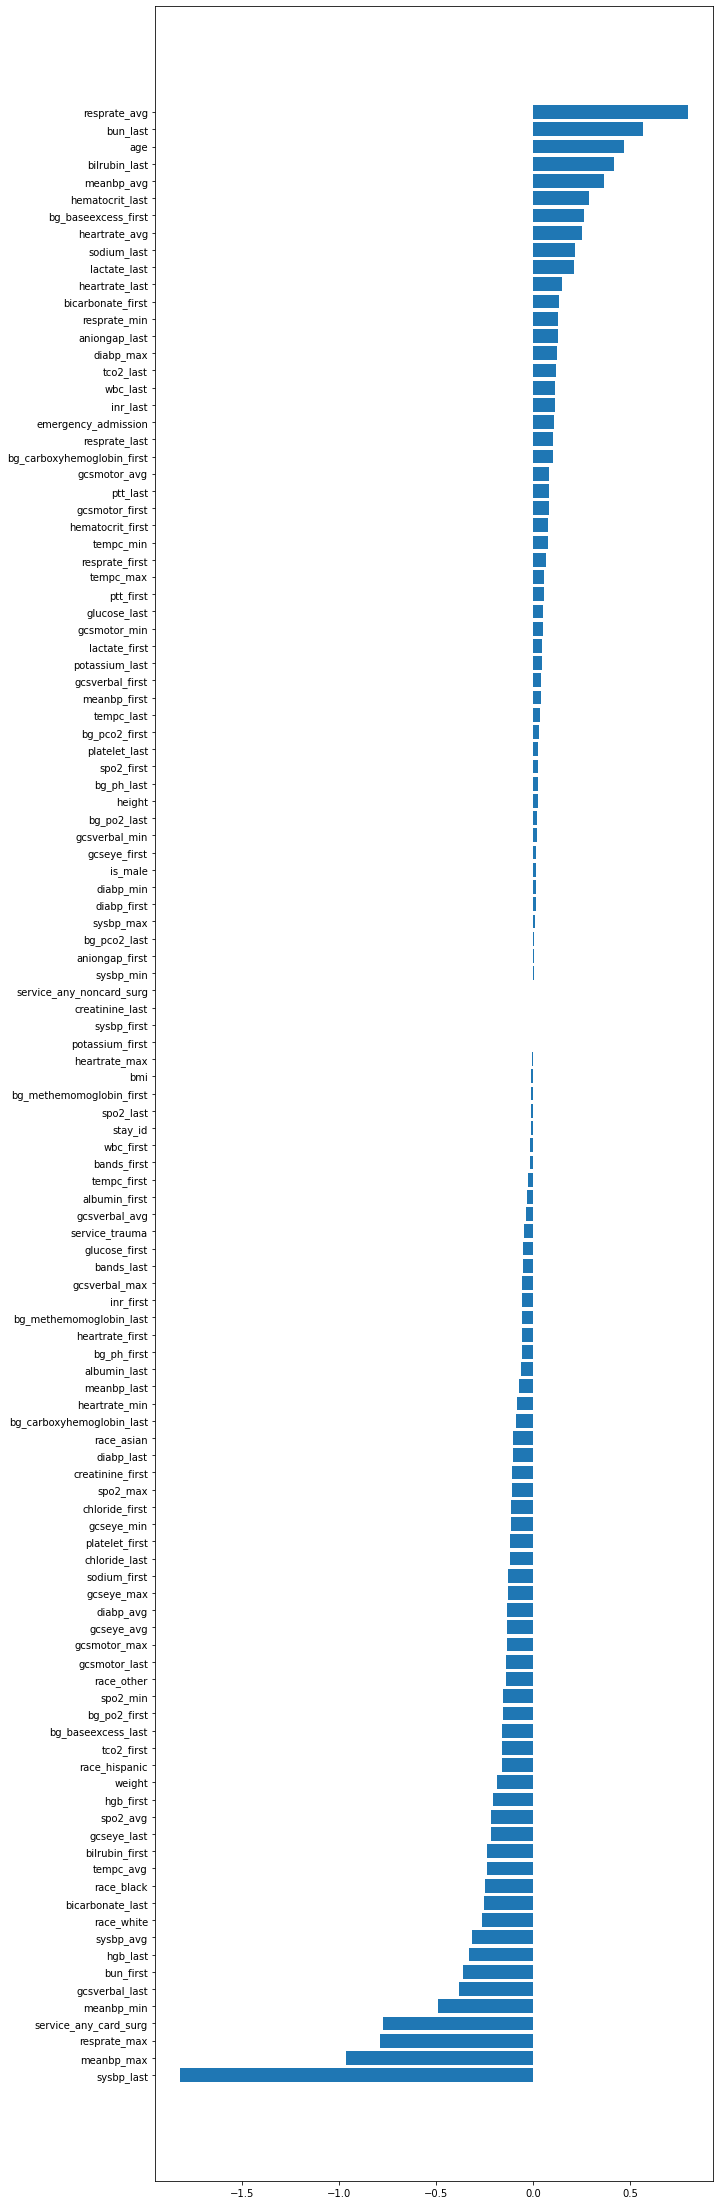

In [101]:
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

### 6.2 XGB Classifier

In [102]:
estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", StandardScaler()),
                      ("xgb" , xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])
mdl = estimator.fit(X_train, y_train)
probs = mdl.predict_proba(X_test)
probs = probs[:,1]
preds = mdl.predict(X_test)

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [103]:
# calculate score (AUROC)
roc_score = metrics.roc_auc_score(y_test, probs)
roc_score

0.9105131916651292

In [104]:
# calculate score (AUROC)
classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      9791
           1       0.72      0.35      0.47      1131

    accuracy                           0.92     10922
   macro avg       0.82      0.67      0.72     10922
weighted avg       0.91      0.92      0.91     10922



In [105]:
data = []
feature_imp_dict = mdl.named_steps['xgb'].get_booster().get_score(importance_type="gain")
for feature_imp in feature_imp_dict:
    data.append([X_header[int(feature_imp[1:])], feature_imp_dict[feature_imp]])
xgbDf = pd.DataFrame(data, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)

<BarContainer object of 99 artists>

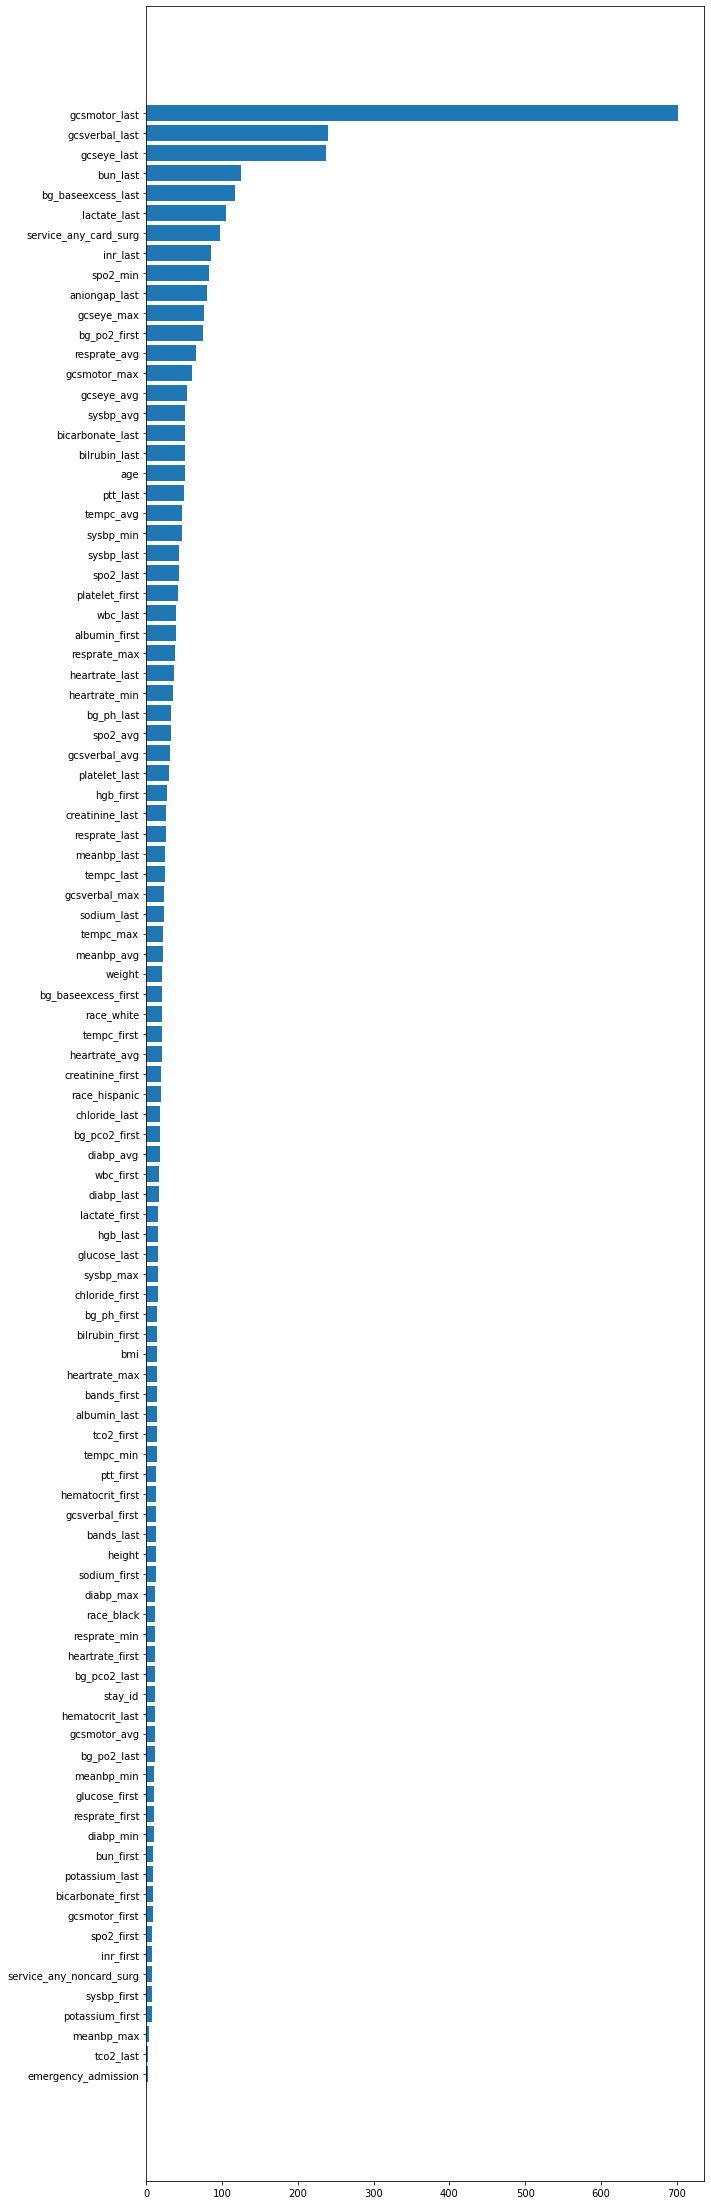

In [107]:
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### 6.3 Neural Network

#### 6.3.1 Using SKLearn

In [129]:
estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", StandardScaler()),
                      ("mlp" , MLPClassifier(hidden_layer_sizes=10))])
mdl = estimator.fit(X_train, y_train)
probs = mdl.predict_proba(X_test)
probs = probs[:,1]
preds = mdl.predict(X_test)

In [130]:
# calculate score (AUROC)
roc_score = metrics.roc_auc_score(y_test, probs)
roc_score

0.8970490321097316

In [131]:
# calculate score (AUROC)
classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9791
           1       0.62      0.45      0.52      1131

    accuracy                           0.91     10922
   macro avg       0.78      0.71      0.74     10922
weighted avg       0.91      0.91      0.91     10922



#### 6.3.2 Using Keras

In [209]:
from keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.impute import SimpleImputer

X_train_array = np.asarray(X_train).astype('float32')
X_test_array = np.asarray(X_test).astype('float32')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_array)
X_train_imputed = imp_mean.transform(X_train_array)
X_test_imputed = imp_mean.transform(X_test_array)
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_imputed)
X_train_noralized = normalizer(X_train_imputed)
X_test_noralized = normalizer(X_test_imputed)

model = Sequential()
model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

Epoch 1/5
171/171 [==============================] - 3s 9ms/step - loss: 0.3116 - accuracy: 0.8914 - val_loss: 0.2608 - val_accuracy: 0.9108
Epoch 2/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.9148 - val_loss: 0.2474 - val_accuracy: 0.9135
Epoch 3/5
171/171 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.9204 - val_loss: 0.2462 - val_accuracy: 0.9142
Epoch 4/5
171/171 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9223 - val_loss: 0.2435 - val_accuracy: 0.9141
Epoch 5/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9252 - val_loss: 0.2452 - val_accuracy: 0.9127


In [210]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_88 (ModuleWra (None, 114)               13110     
_________________________________________________________________
module_wrapper_89 (ModuleWra (None, 40)                4600      
_________________________________________________________________
module_wrapper_90 (ModuleWra (None, 1)                 41        
Total params: 17,751
Trainable params: 17,751
Non-trainable params: 0
_________________________________________________________________


In [222]:
probs = model.predict_proba(X_test_noralized)
preds = np.around(probs)

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [223]:
# calculate score (AUROC)
roc_score = metrics.roc_auc_score(y_test, probs)
roc_score

0.9008462092029337

In [224]:
# calculate score (AUROC)
classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9791
           1       0.61      0.43      0.51      1131

    accuracy                           0.91     10922
   macro avg       0.77      0.70      0.73     10922
weighted avg       0.90      0.91      0.91     10922

